<a href="https://colab.research.google.com/github/ezrake/Automated-Class-Attendance-Logging/blob/main/automated_class_attendance_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mtcnn

     |████████████████████████████████| 2.3MB 4.7MB/s 


In [ ]:
import numpy as np
import pandas as pd
import os
import random

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

from mtcnn.mtcnn import MTCNN

import warnings
warnings.filterwarnings('ignore')

In [ ]:
PATH = '/content/drive/MyDrive/automated_class_attendance/data/train/Elena/'

ROOT_PATH = '/content/drive/MyDrive/automated_class_attendance/data/'

TRAIN_PATH = '/content/drive/MyDrive/automated_class_attendance/data/train/'

VAL_PATH = '/content/drive/MyDrive/automated_class_attendance/data/val/'

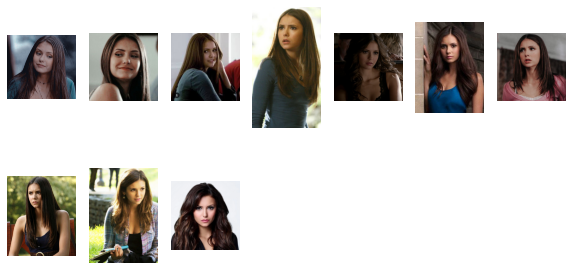

In [ ]:
plt.figure(figsize=(10,5))
for i, filename in enumerate(os.listdir(PATH)):
    path = PATH + filename
    image = plt.imread(path)
    
    plt.subplot(2, 7, i+1)
    
    plt.axis('off')
    plt.imshow(image)
    
plt.show()

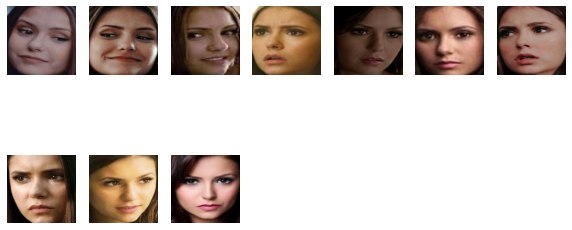

In [ ]:
def extract_face(detector, filename, required_size=(160, 160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    
    results = detector.detect_faces(pixels)
    
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    
    x2, y2 = x1 + width, y1 + height
    
    face = pixels[y1:y2, x1:x2]
    
    image = Image.fromarray(face)
    
    image = image.resize(required_size)
    face_array = np.asarray(image)
    
    return face_array

detector = MTCNN()
plt.figure(figsize=(10,5))
for i, filename in enumerate(os.listdir(PATH)):
    path = PATH + filename
    
    face = extract_face(detector, path)
    
    #print(i+1, face.shape)
    
    plt.subplot(2, 7, i+1)
    
    plt.axis('off')
    plt.imshow(face)
    
plt.show()

In [ ]:
def load_faces(directory):
    faces = list()
    for file_name in os.listdir(directory):
        path = directory + file_name
        face = extract_face(detector, path)
        
        faces.append(face)
    return faces

def load_dataset(directory):
    images, labels = list(), list()
    for folder in os.listdir(directory):
        path = directory + folder + '/'
        
        if not os.path.isdir(path):
            continue
        
        faces = load_faces(path)

        print(f'Celebrity : {folder}, Faces : {len(faces)}')

        label = [folder for _ in range(len(faces))]

        images.extend(faces)
        labels.extend(label)
        
    return np.asarray(images), np.asarray(labels)

In [ ]:
X_train, y_train = load_dataset(TRAIN_PATH)
X_val, y_val = load_dataset(VAL_PATH)

Celebrity : Matt, Faces : 14
Celebrity : Damon, Faces : 10
Celebrity : Stefan, Faces : 13
Celebrity : Elena, Faces : 10
Celebrity : Rebekah, Faces : 12
Celebrity : Damon, Faces : 4
Celebrity : Elena, Faces : 4
Celebrity : Matt, Faces : 5
Celebrity : Rebekah, Faces : 4
Celebrity : Stefan, Faces : 4


In [ ]:
X_val.shape

(21, 160, 160, 3)

In [ ]:
X_train.shape

(59, 160, 160, 3)

In [ ]:
from keras.models import load_model

def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
     
    mean, std = face_pixels.mean(), face_pixels.std() 
    face_pixels = (face_pixels - mean) / std
    
    samples = np.expand_dims(face_pixels, axis=0)
    yhat = model.predict(samples)
    
    return yhat[0]

model = load_model('/content/drive/MyDrive/automated_class_attendance/models/facenet_keras.h5')


trainX = list()

for pixels in X_train:
    embedding = get_embedding(model, pixels)
    trainX.append(embedding)
trainX = np.asarray(trainX)


valX = list()

for pixels in X_val:
    embedding = get_embedding(model, pixels)
    valX.append(embedding)
valX = np.asarray(valX)


In [ ]:
valX.shape

(21, 128)

In [ ]:

trainX.shape

(59, 128)

In [ ]:
norm = Normalizer(norm='l2')

trainX = norm.transform(trainX)
valX = norm.transform(valX)

label = LabelEncoder()

trainy = label.fit_transform(y_train)
valy = label.fit_transform(y_val)

model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

yhat_train = model.predict(trainX)
yhat_val = model.predict(valX)

score_train = accuracy_score(trainy, yhat_train)
score_val = accuracy_score(valy, yhat_val)

print('Accuracy: train=%.3f, val=%.3f' % (score_train*100, score_val*100))

Accuracy: train=100.000, val=100.000


In [ ]:
def extract_faces(filename, size=(160, 160)):
  all_faces = list()
  image = Image.open(filename)
  image = image.convert('RGB')
  pixels = np.asarray(image)

  detector = MTCNN()
  results = detector.detect_faces(pixels)
 
  for result in results:
    x1, y1, width, height = result['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height

    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(size)
    face_array  = np.asarray(image)

    all_faces.append(face_array)
  all_faces = np.asarray(all_faces)
  return all_faces

In [ ]:
test = extract_faces('/content/drive/MyDrive/automated_class_attendance/data/test/stefan_rebekah/test3.png')

testX = list()

facenet_model = load_model('/content/drive/MyDrive/automated_class_attendance/models/facenet_keras.h5')

for pixels in test:
  embedding = get_embedding(facenet_model, pixels)
  testX.append(embedding)
testX = np.asarray(testX)

In [ ]:
ans = model.predict(testX)


array(['Rebekah', 'Elena', 'Stefan', 'Rebekah'], dtype='<U7')

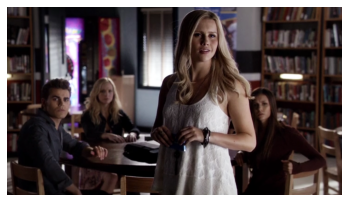

In [ ]:
path = '/content/drive/MyDrive/automated_class_attendance/data/test/stefan_rebekah/test3.png'
image = plt.imread(path)
      
plt.axis('off')
plt.imshow(image)

label.inverse_transform(ans)

In [ ]:
attendance_report  = label.inverse_transform(ans)
attendance_report = attendance_report.tolist()

report_file = open("/content/drive/MyDrive/automated_class_attendance/report_file.txt", "w")

for student_record in attendance_report:

    report_file.write(student_record + "\n")
report_file.close()

Probability : 75.6422969445173, 
Celebrity - Predicted : ['Rebekah'], Actual : Rebekah


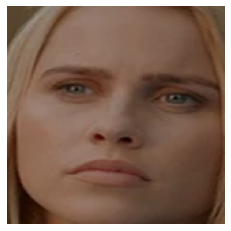

In [ ]:
random.seed(50)
selection = random.choice([i for i in range(valX.shape[0])])

face = X_val[selection]

yhat_prob = model.predict_proba(valX[selection].reshape(1,-1))
yhat = model.predict(valX[selection].reshape(1,-1))

celeb = label.inverse_transform(yhat)

plt.imshow(face)
plt.axis('off')

print(f'Probability : {np.max(yhat_prob)*100}, \nCelebrity - Predicted : {celeb}, Actual : {y_val[selection]}')

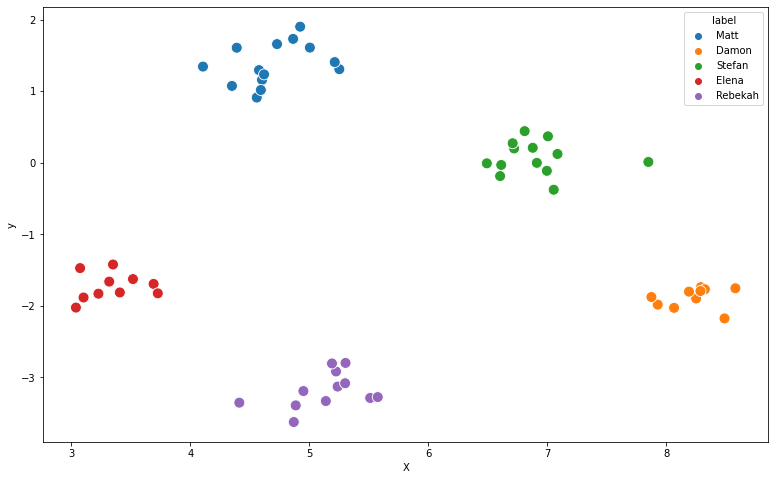

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(learning_rate=100)

tsne_features = tsne.fit_transform(trainX)

X = tsne_features[:,0]
y = tsne_features[:,1]

dataset = pd.DataFrame(data=y_train, columns=['label'])
dataset['X'] = X
dataset['y'] = y

plt.figure(figsize=(13,8))
sns.scatterplot(data=dataset, x='X', y='y', hue='label', s=120)

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: